# Link Prediction

In [118]:
import networkx as nx
from torch_geometric.utils import from_networkx, negative_sampling
from torch_geometric.data import Data
import torch
import numpy as np
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE, GAE, GAT
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

## 1. Data analysis

In [2]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")

In [3]:
print("number of nodes: ", len(g.nodes))
print("number of edges: ", len(g.edges))

number of nodes:  3363
number of edges:  13547


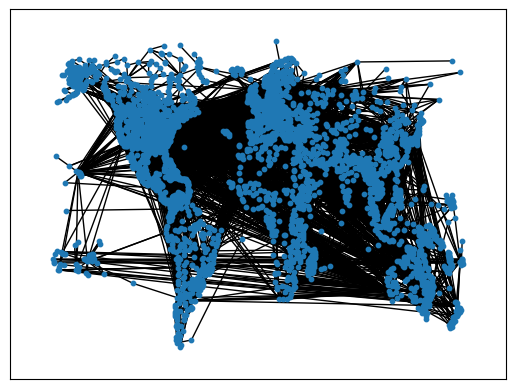

In [4]:
pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
nx.draw_networkx(g, pos=pos, node_size=10, with_labels=False)

With Gephi we have optain this graph:
![](./gephi_analyse/airports_coord_pop_graph.svg)

In [5]:
#Example of the a node
g.nodes()['0']

{'lon': -145.50972222222222,
 'lat': -17.35388888888889,
 'population': 10000,
 'country': 'FRENCH_POLYNESIA',
 'city_name': 'Anaa'}

In [6]:
g.graph = {}
data = from_networkx(g, group_node_attrs=["lon", "lat"])
edge_index = data.edge_index
data: Data = train_test_split_edges(data)   
data.edge_index = edge_index
data

c:\Users\arthu\miniconda3\envs\pytorchgeo\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 2], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354], edge_index=[2, 27094])

- x=[3363, 2] => pour chaque noeud, les coordonnées lat et lon
- val_pos_edge_index=[2, 677] => 2 ligne, la première c'est d'où on pars, la deuxième c'est où on va
- test_pos_edge_index=[2, 1354] => /
- train_pos_edge_index=[2, 23032] => /
- train_neg_adj_mask=[3363, 3363] => matrice d'adjacence, vrai si pas de lien, faux sinon
- val_neg_edge_index=[2, 677] => /
- test_neg_edge_index=[2, 1354] => /


## 2. First Model VGAE/GAE

### GAE with GAE Encoder

In [9]:
class GAEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = GCNConv(2*out_channels, out_channels, cached=True)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [11]:
def trainGAE(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(model, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [13]:
model = GAE(GAEncoder(data.num_features, 2))
optim = torch.optim.Adam(model.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
for epoch in range(500):
    better = False
    loss = trainGAE(model, optim, data)

    auc, ap = test(model, data.val_pos_edge_index, data.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bmodel = model
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print("##FINAL TEST##")
auc, ap = test(bmodel, data.test_pos_edge_index, data.test_neg_edge_index)
print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))


    Epoch: 000, AUC: 0.7152, AP: 0.6416
    Epoch: 001, AUC: 0.7201, AP: 0.6460
    Epoch: 002, AUC: 0.7203, AP: 0.6463
    Epoch: 003, AUC: 0.7210, AP: 0.6470
Epoch: 004, AUC: 0.7204, AP: 0.6465
    Epoch: 005, AUC: 0.7228, AP: 0.6488
Epoch: 006, AUC: 0.7225, AP: 0.6488
Epoch: 007, AUC: 0.7221, AP: 0.6488
    Epoch: 008, AUC: 0.7231, AP: 0.6499
Epoch: 009, AUC: 0.7225, AP: 0.6496
    Epoch: 010, AUC: 0.7263, AP: 0.6538
    Epoch: 011, AUC: 0.7268, AP: 0.6543
Epoch: 012, AUC: 0.7224, AP: 0.6498
Epoch: 013, AUC: 0.7201, AP: 0.6475
Epoch: 014, AUC: 0.7183, AP: 0.6466
Epoch: 015, AUC: 0.7232, AP: 0.6517
Epoch: 016, AUC: 0.7219, AP: 0.6499
Epoch: 017, AUC: 0.7224, AP: 0.6507
    Epoch: 018, AUC: 0.7288, AP: 0.6578
    Epoch: 019, AUC: 0.7298, AP: 0.6602
    Epoch: 020, AUC: 0.7302, AP: 0.6619
    Epoch: 021, AUC: 0.7308, AP: 0.6629
    Epoch: 022, AUC: 0.7342, AP: 0.6674
Epoch: 023, AUC: 0.7341, AP: 0.6679
    Epoch: 024, AUC: 0.7388, AP: 0.6734
    Epoch: 025, AUC: 0.7471, AP: 0.6839
    

### Visualise the map with the result of decoder

In [18]:
def visualise_output_prediction(bmodel, data, g):
    z = bmodel.encode(data.x, data.train_pos_edge_index)
    Ahat = (z @ z.T).softmax(dim=1)
    print(Ahat)
    Ahat = Ahat-torch.eye(len(Ahat), len(Ahat))
    rows, cols = np.where(Ahat > 0.0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = g.copy()
    gr.remove_edges_from(list(gr.edges()))
    for u, v in edges:
        if str(u) in gr.nodes and str(v) in gr.nodes:
            gr.add_edge(str(u), str(v))
    print("number of nodes:", len(gr.nodes))
    print("number of edges:", len(gr.edges))
    pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
    nx.draw_networkx(gr, pos=pos, node_size=10, with_labels=False)
# visualise_output_prediction(bmodel, data, g)

### VGAE with VGAE encoder 

In [14]:
class VGAEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VGAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv_mu = GCNConv(2*out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2*out_channels, out_channels, cached=True)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [15]:
def trainVGAE(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

In [16]:
model = VGAE(VGAEncoder(data.num_features, 2))
optim = torch.optim.Adam(model.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
for epoch in range(500):
    better = False
    loss = trainVGAE(model, optim, data)

    auc, ap = test(model, data.val_pos_edge_index, data.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bmodel = model
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print("##FINAL TEST##")
auc, ap = test(bmodel, data.test_pos_edge_index, data.test_neg_edge_index)
print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))

    Epoch: 000, AUC: 0.4993, AP: 0.4996
Epoch: 001, AUC: 0.4985, AP: 0.4993
Epoch: 002, AUC: 0.4985, AP: 0.4993
Epoch: 003, AUC: 0.4985, AP: 0.4993
Epoch: 004, AUC: 0.4993, AP: 0.4996
Epoch: 005, AUC: 0.4993, AP: 0.4996
Epoch: 006, AUC: 0.4993, AP: 0.4996
    Epoch: 007, AUC: 0.5000, AP: 0.5000
    Epoch: 008, AUC: 0.5029, AP: 0.5015
    Epoch: 009, AUC: 0.5037, AP: 0.5019
    Epoch: 010, AUC: 0.5066, AP: 0.5034
    Epoch: 011, AUC: 0.5067, AP: 0.5034
    Epoch: 012, AUC: 0.5081, AP: 0.5041
    Epoch: 013, AUC: 0.5148, AP: 0.5075
    Epoch: 014, AUC: 0.5185, AP: 0.5094
    Epoch: 015, AUC: 0.5229, AP: 0.5118
Epoch: 016, AUC: 0.5229, AP: 0.5118
    Epoch: 017, AUC: 0.5229, AP: 0.5118
    Epoch: 018, AUC: 0.5251, AP: 0.5129
Epoch: 019, AUC: 0.5251, AP: 0.5129
    Epoch: 020, AUC: 0.5273, AP: 0.5141
    Epoch: 021, AUC: 0.5303, AP: 0.5157
    Epoch: 022, AUC: 0.5333, AP: 0.5173
    Epoch: 023, AUC: 0.5363, AP: 0.5189
    Epoch: 024, AUC: 0.5407, AP: 0.5213
    Epoch: 025, AUC: 0.5475, AP:

### Hyperparameter tuning

In [127]:
def hyperparameter_tuning_grid_search(data, output_values, lr_values, model, encoder, name_of_runs, train_fonction, hidden_values = []):
    for out in output_values:
        for hid in hidden_values:
            if hidden_values != []:
                trained_model = model(encoder(data.num_features, hid, out))
            else :
                trained_model = model(encoder(data.num_features, out))
            for lr in lr_values:
                optim = torch.optim.Adam(trained_model.parameters(), lr=lr)
                writer = SummaryWriter('runs/'+name_of_runs+f'/__{str(out)}_out_{str(lr)}_lr')
                bmodel = None
                bauc = float("-inf")
                bepoch = -1
                for epoch in range(500):
                    better = False
                    loss = train_fonction(trained_model, optim, data)
                    writer.add_scalar(
                        "train/loss", loss, epoch
                    )
                    auc, ap = test(trained_model, data.val_pos_edge_index, data.val_neg_edge_index)
                    writer.add_scalar(
                        "val/auc", auc, epoch
                    )
                    writer.add_scalar(
                        "val/ap", ap, epoch
                    )
                    if auc > bauc:
                        bauc = auc
                        bmodel = trained_model
                        better = True
                        bepoch = epoch
                    if better:
                        print('OUT: {:03d}, LR: {:.4f}, Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(out, lr, epoch, auc, ap))
                
                print("test")
                t_auc, t_ap = test(bmodel, data.test_pos_edge_index, data.test_neg_edge_index)
                print('AUC: {:.4f}, AP: {:.4f}'.format(t_auc, t_ap))
                print()
                writer.add_hparams(
                    {
                        "lr": lr,
                        "out": out,
                        "epoch": bepoch,
                    },
                    {
                        "hparam/AUC": t_auc,
                        "hparam/AP": t_ap,
                    },
                )
        

In [23]:
# Choice made randomly
import random
output_values = random.sample(range(2, 30), 3)
lr_values = [random.uniform(0.01, 0.00001) for _ in range(3)]
hyperparameter_tuning_grid_search(data, output_values, lr_values, GAE, GAEncoder, 'GAE_train2', trainGAE)

OUT: 016, LR: 0.0098, Epoch: 000, AUC: 0.6911, AP: 0.6186
OUT: 016, LR: 0.0098, Epoch: 001, AUC: 0.7078, AP: 0.6321
OUT: 016, LR: 0.0098, Epoch: 002, AUC: 0.7122, AP: 0.6365
OUT: 016, LR: 0.0098, Epoch: 003, AUC: 0.7178, AP: 0.6411
OUT: 016, LR: 0.0098, Epoch: 004, AUC: 0.7210, AP: 0.6437
OUT: 016, LR: 0.0098, Epoch: 005, AUC: 0.7233, AP: 0.6454
OUT: 016, LR: 0.0098, Epoch: 010, AUC: 0.7251, AP: 0.6475
OUT: 016, LR: 0.0098, Epoch: 011, AUC: 0.7285, AP: 0.6503
OUT: 016, LR: 0.0098, Epoch: 012, AUC: 0.7304, AP: 0.6519
OUT: 016, LR: 0.0098, Epoch: 013, AUC: 0.7340, AP: 0.6552
OUT: 016, LR: 0.0098, Epoch: 014, AUC: 0.7353, AP: 0.6563
OUT: 016, LR: 0.0098, Epoch: 015, AUC: 0.7366, AP: 0.6576
OUT: 016, LR: 0.0098, Epoch: 016, AUC: 0.7379, AP: 0.6587
OUT: 016, LR: 0.0098, Epoch: 017, AUC: 0.7402, AP: 0.6608
OUT: 016, LR: 0.0098, Epoch: 018, AUC: 0.7423, AP: 0.6628
OUT: 016, LR: 0.0098, Epoch: 020, AUC: 0.7437, AP: 0.6640
OUT: 016, LR: 0.0098, Epoch: 021, AUC: 0.7468, AP: 0.6671
OUT: 016, LR: 

In [19]:
# Choice made randomly
import random
output_values = random.sample(range(2, 30), 3)
lr_values = [random.uniform(0.01, 0.00001) for _ in range(3)]
hyperparameter_tuning_grid_search(data, output_values, lr_values, VGAE, VGAEncoder, 'VGAE_train2', trainVGAE)

OUT: 024, LR: 0.0013, Epoch: 000, AUC: 0.5140, AP: 0.5071
OUT: 024, LR: 0.0013, Epoch: 001, AUC: 0.5148, AP: 0.5075
OUT: 024, LR: 0.0013, Epoch: 002, AUC: 0.5155, AP: 0.5079
OUT: 024, LR: 0.0013, Epoch: 004, AUC: 0.5162, AP: 0.5083
OUT: 024, LR: 0.0013, Epoch: 005, AUC: 0.5177, AP: 0.5090
OUT: 024, LR: 0.0013, Epoch: 006, AUC: 0.5185, AP: 0.5094
OUT: 024, LR: 0.0013, Epoch: 007, AUC: 0.5214, AP: 0.5109
OUT: 024, LR: 0.0013, Epoch: 008, AUC: 0.5222, AP: 0.5113
OUT: 024, LR: 0.0013, Epoch: 012, AUC: 0.5244, AP: 0.5125
OUT: 024, LR: 0.0013, Epoch: 013, AUC: 0.5251, AP: 0.5129
OUT: 024, LR: 0.0013, Epoch: 014, AUC: 0.5259, AP: 0.5133
OUT: 024, LR: 0.0013, Epoch: 015, AUC: 0.5296, AP: 0.5153
OUT: 024, LR: 0.0013, Epoch: 016, AUC: 0.5311, AP: 0.5161
OUT: 024, LR: 0.0013, Epoch: 017, AUC: 0.5334, AP: 0.5173
OUT: 024, LR: 0.0013, Epoch: 018, AUC: 0.5415, AP: 0.5217
OUT: 024, LR: 0.0013, Epoch: 019, AUC: 0.5644, AP: 0.5345
OUT: 024, LR: 0.0013, Epoch: 020, AUC: 0.6075, AP: 0.5602
OUT: 024, LR: 

## 3. Second Model GAT

### GatEncoder with Vgae

In [119]:
class GATEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.6)
        self.conv2_mu = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)
        self.conv2_logstd = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)
    

In [133]:
def trainGAT(model, opti, data):
    model.train()
    opti.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    opti.step()
    return float(loss)

In [130]:
modelGAT = VGAE(GATEncoder(input_dim=data.num_node_features, hidden_dim=8, output_dim=16))
optim = torch.optim.Adam(modelGAT.parameters(), lr=0.01)
bmodel = None
bauc = float("-inf")
bap = float("-inf")
for epoch in range(500):
    better = False
    loss = trainGAT(modelGAT, optim, data, data.train_pos_edge_index)

    auc, ap = test(modelGAT, data.val_pos_edge_index, data.val_neg_edge_index)
    if auc > bauc:
        bauc = auc
        bap = ap
        bmodel = modelGAT
        better = True
    if better:
        print('    Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    else:    
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

print('BEST AUC: {:.4f}, AP: {:.4f}'.format(bauc, bap))

    Epoch: 000, AUC: 0.6730, AP: 0.6052
Epoch: 001, AUC: 0.6729, AP: 0.6052
    Epoch: 002, AUC: 0.6761, AP: 0.6074
    Epoch: 003, AUC: 0.6769, AP: 0.6080
Epoch: 004, AUC: 0.6719, AP: 0.6043
Epoch: 005, AUC: 0.6652, AP: 0.5995
Epoch: 006, AUC: 0.6598, AP: 0.5954
Epoch: 007, AUC: 0.6590, AP: 0.5948
Epoch: 008, AUC: 0.6610, AP: 0.5962
Epoch: 009, AUC: 0.6588, AP: 0.5947
Epoch: 010, AUC: 0.6588, AP: 0.5946


KeyboardInterrupt: 

In [135]:
# Choice made randomly
import random
hidden_values = random.sample(range(30, 60), 1)
output_values = random.sample(range(2, 30), 1)
lr_values = [random.uniform(0.01, 0.00001) for _ in range(1)]
hyperparameter_tuning_grid_search(data, output_values, lr_values, VGAE, GATEncoder, 'GAT_train2', trainGAT, hidden_values=hidden_values)

OUT: 028, LR: 0.0023, Epoch: 000, AUC: 0.5525, AP: 0.5277
OUT: 028, LR: 0.0023, Epoch: 001, AUC: 0.5946, AP: 0.5523
OUT: 028, LR: 0.0023, Epoch: 002, AUC: 0.6272, AP: 0.5729
OUT: 028, LR: 0.0023, Epoch: 003, AUC: 0.6568, AP: 0.5930
OUT: 028, LR: 0.0023, Epoch: 008, AUC: 0.6588, AP: 0.5948
OUT: 028, LR: 0.0023, Epoch: 009, AUC: 0.6695, AP: 0.6025
OUT: 028, LR: 0.0023, Epoch: 010, AUC: 0.6733, AP: 0.6054
OUT: 028, LR: 0.0023, Epoch: 011, AUC: 0.6830, AP: 0.6130
OUT: 028, LR: 0.0023, Epoch: 012, AUC: 0.6854, AP: 0.6149
OUT: 028, LR: 0.0023, Epoch: 013, AUC: 0.6867, AP: 0.6159
OUT: 028, LR: 0.0023, Epoch: 014, AUC: 0.6882, AP: 0.6171
OUT: 028, LR: 0.0023, Epoch: 015, AUC: 0.6888, AP: 0.6175
OUT: 028, LR: 0.0023, Epoch: 025, AUC: 0.6947, AP: 0.6219
OUT: 028, LR: 0.0023, Epoch: 026, AUC: 0.6982, AP: 0.6250
OUT: 028, LR: 0.0023, Epoch: 027, AUC: 0.7041, AP: 0.6300
OUT: 028, LR: 0.0023, Epoch: 028, AUC: 0.7093, AP: 0.6347
OUT: 028, LR: 0.0023, Epoch: 029, AUC: 0.7126, AP: 0.6376
OUT: 028, LR: 